# Silicon Nanowire with Coulomb screening

You can run this example with a batch submission script like the
following on `daint.alps`:
```bash
#!/bin/bash -l
#SBATCH --job-name="si-nanowire"
#SBATCH --time=02:00:00
#SBATCH --nodes=20
#SBATCH --ntasks-per-node=4
#SBATCH --cpus-per-task=64
#SBATCH --gpus-per-task=1
#SBATCH --partition=normal
#SBATCH --constraint=gpu
#SBATCH --hint=nomultithread
#SBATCH --uenv=prgenv-gnu/24.7:v3
#SBATCH --view=modules

set -e -u

export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
export MPICH_GPU_SUPPORT_ENABLED=1
export OMP_PROC_BIND=true
export OMP_PLACES=cores

source ~/load_modules.sh
conda activate quatrex

srun --cpu-bind=socket python "$QUATREX_PATH/examples/w90/si-nw/run.py"

```

You may want to adjust the number of threads per rank in the `run.py`
script.

With the provided energy vector, this example ran at around 80s per
iteration on 20 `daint` nodes.

In [1]:
import glob
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from quatrex.core.quatrex_config import parse_config
from quatrex.post_processing.plot_ldos import get_averages, spectral_plot

simulation_dir = Path("./")

input_dir = simulation_dir / "inputs"
output_dir = simulation_dir / "outputs"

config = parse_config(simulation_dir / "config.toml")

## Convergence information

In [ ]:
with open(simulation_dir / "slurm-xxxxxx.out") as f:
    out = f.readlines()

In [3]:
maximum_self_energy_updates = [
    float(line.split()[-1]) for line in out if "Maximum Self-Energy Update" in line
]
average_current_changes = [
    float(line.split()[-1]) for line in out if line.startswith("Average Current Change")
]
relative_average_current_changes = [
    float(line.split()[-1]) for line in out if "Relative Average Current Change" in line
]
current_differences = [
    float(line.split()[-1]) for line in out if "Current Difference" in line
]
relative_current_conservations = [
    float(line.split()[-1]) for line in out if "Relative Current Conservation" in line
]
right_conduction_band_edges = [
    float(line.split()[-1]) for line in out if "Updating conduction band" in line
]
left_conduction_band_edges = [
    float(line.split()[-2].strip(","))
    for line in out
    if "Updating conduction band" in line
]
iterations = [int(line.split()[-1]) for line in out if "Iteration" in line]

Text(0.5, 1.0, 'Maximum Self-Energy Update')

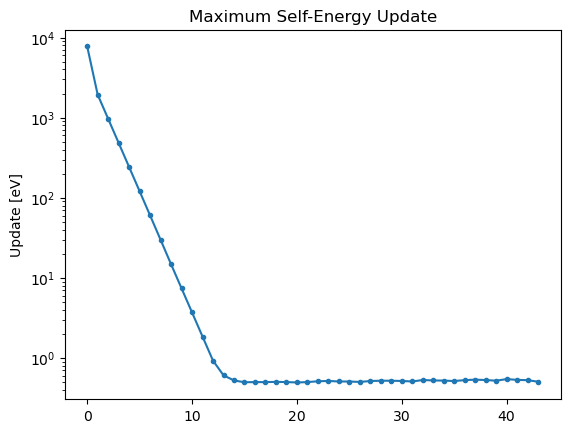

In [4]:
fig, ax_self_energy = plt.subplots()

ax_self_energy.plot(maximum_self_energy_updates, marker=".")
ax_self_energy.set_yscale("log")
ax_self_energy.set_ylabel("Update [eV]")
ax_self_energy.set_title("Maximum Self-Energy Update")


## Contact currents

In [5]:
left_files = sorted(
    glob.glob(str(output_dir / "i_left_*.npy")),
    key=lambda s: int(s.split("_")[-1][:-4]),
)
right_files = sorted(
    glob.glob(str(output_dir / "i_right_*.npy")),
    key=lambda s: int(s.split("_")[-1][:-4]),
)

left_currents = np.array([np.load(f) for f in left_files[:]])
right_currents = np.array([np.load(f) for f in right_files[:]])

Text(0, 0.5, 'Energy (eV)')

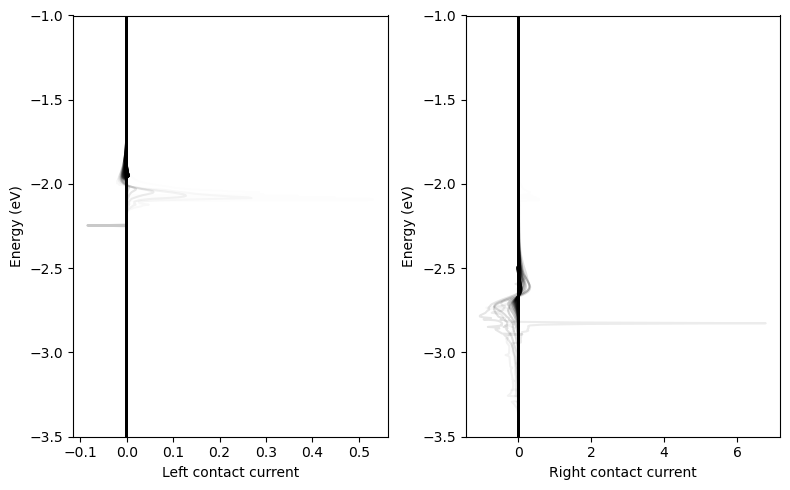

In [6]:
energies = np.load(input_dir / "electron_energies.npy")

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(8, 5), layout="tight")

num_iterations = len(left_currents)

for i, (left_current, right_current) in enumerate(zip(left_currents, right_currents)):
    ax_left.plot(
        -left_current.real, energies, "k", alpha=(i + 0.3) / (num_iterations + 0.3)
    )
    ax_right.plot(
        right_current.real, energies, "k", alpha=(i + 0.3) / (num_iterations + 0.3)
    )
    ax_left.set_ylim(-3.5, -1)
    ax_right.set_ylim(-3.5, -1)

ax_left.set_xlabel("Left contact current")
ax_right.set_xlabel("Right contact current")
ax_left.set_ylabel("Energy (eV)")
ax_right.set_ylabel("Energy (eV)")
# ax_left.set_xscale("log")
# ax_right.set_xscale("log")

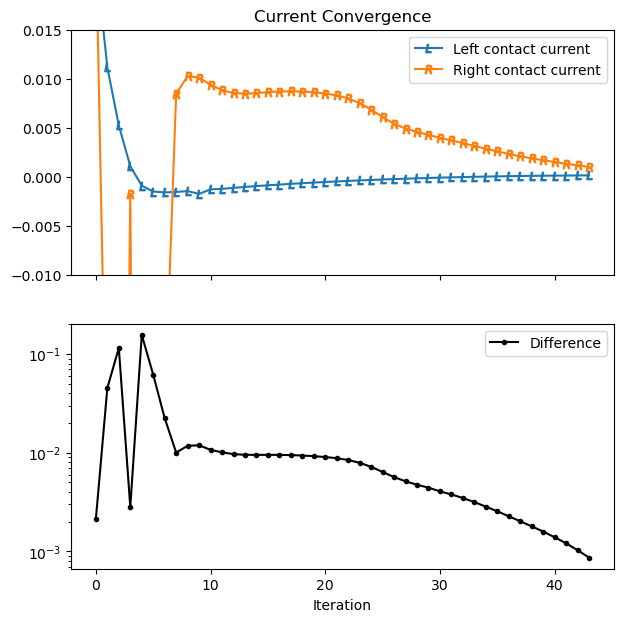

In [7]:
fig, (ax_currents, ax_diff) = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
dE = energies[1] - energies[0]
ax_currents.plot(
    -left_currents.sum(1).real * dE,
    label="Left contact current",
    marker="$L$",
)
ax_currents.plot(
    right_currents.sum(1).real * dE,
    label="Right contact current",
    marker="$R$",
)
diff = +left_currents.sum(1).real * dE + right_currents.sum(1).real * dE
ax_diff.plot(np.abs(diff), label="Difference", color="k", marker=".")

ax_diff.legend()
ax_currents.legend()
ax_currents.set_title("Current Convergence")
ax_currents.set_ylim(-0.01, 1.5e-2)
ax_diff.set_xlabel("Iteration")
ax_diff.set_yscale("log")

# Device currents

In [8]:
meir_wingreen_current_files = sorted(
    glob.glob(str(output_dir / "meir_wingreen_current_*.npy")),
    key=lambda s: int(s.split("_")[-1][:-4]),
)
device_current_files = sorted(
    glob.glob(str(output_dir / "device_current_*.npy")),
    key=lambda s: int(s.split("_")[-1][:-4]),
)

meir_wingreen_currents = np.array([np.load(f) for f in meir_wingreen_current_files[:]])
device_currents = np.array([np.load(f) for f in device_current_files[:]])

Text(0.5, 0, 'Iteration')

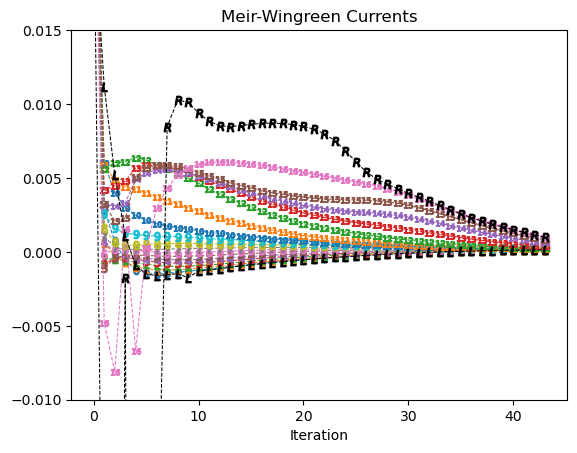

In [9]:
fig, ax = plt.subplots()

for i in range(meir_wingreen_currents.shape[-1]):
    ax.plot(
        -meir_wingreen_currents[..., i].sum(-1).real * dE,
        marker=f"${i}$",
        ls="--",
        lw=0.75,
    )

ax.set_ylim(-0.01, 1.5e-2)
ax.plot(-left_currents.sum(1).real * dE, marker="$L$", ls="--", color="k", lw=0.75)
ax.plot(right_currents.sum(1).real * dE, marker="$R$", ls="--", color="k", lw=0.75)

ax.set_title("Meir-Wingreen Currents")
ax.set_xlabel("Iteration")

Text(0.5, 0, 'Iteration')

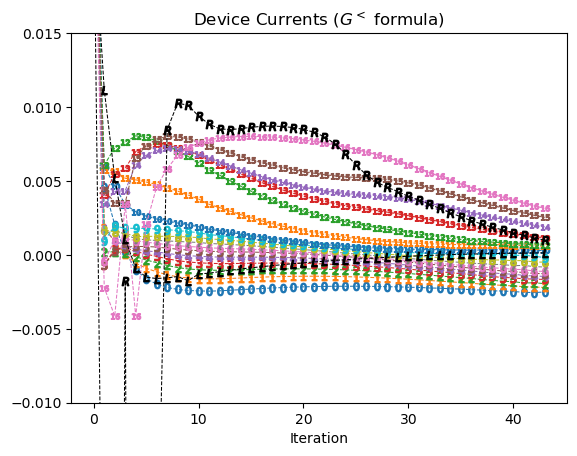

In [10]:
fig, ax = plt.subplots()

for i in range(device_currents.shape[-1]):
    ax.plot(
        device_currents[..., i].sum(-1).real * dE, marker=f"${i}$", ls="--", lw=0.75
    )

ax.set_ylim(-0.01, 1.5e-2)
ax.plot(-left_currents.sum(1).real * dE, marker="$L$", ls="--", color="k", lw=0.75)
ax.plot(right_currents.sum(1).real * dE, marker="$R$", ls="--", color="k", lw=0.75)

ax.set_title("Device Currents ($G^<$ formula)")
ax.set_xlabel("Iteration")

## LDOS at the left contact

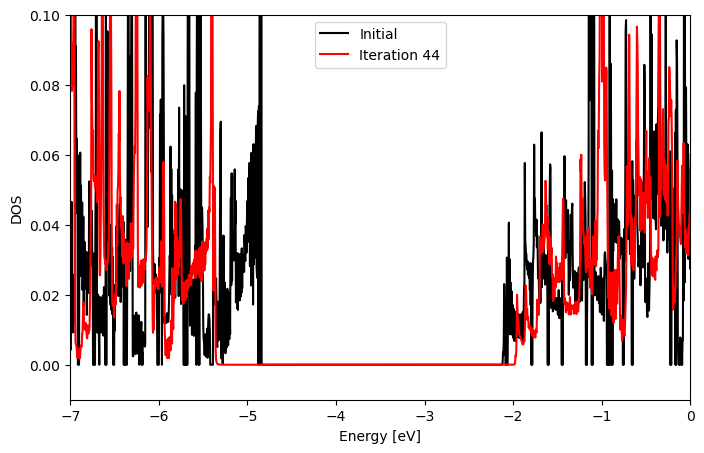

In [11]:
import glob

files = glob.glob(str(output_dir / "electron_ldos_*.npy"))
# DOS of first layer.
files = sorted(
    files,
    key=lambda s: int(s.split("_")[-1][:-4]),
)
doss = np.array([np.load(f)[:, :32].mean(1) for f in files[: iterations[-1]]])
band_gaps = []
# Find peaks to determine band gaps.
for i in range(doss.shape[0]):
    peaks = find_peaks(doss[i], height=0.001)[0]
    peak_energies = energies[peaks]
    mask = (peak_energies - config.electron.left_fermi_level) < 0
    band_gaps.append(np.abs(peak_energies[mask].max() - peak_energies[~mask].min()))


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(
    energies,
    doss[0],
    color="k",
    label="Initial",
)
ax.plot(
    energies,
    doss[-1],
    color="r",
    label=f"Iteration {iterations[-1]}",
)
ax.set_xlim(-7, 0)
ax.set_ylim(-0.01, 0.1)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("DOS")

ax.legend()

## Band gap over iterations

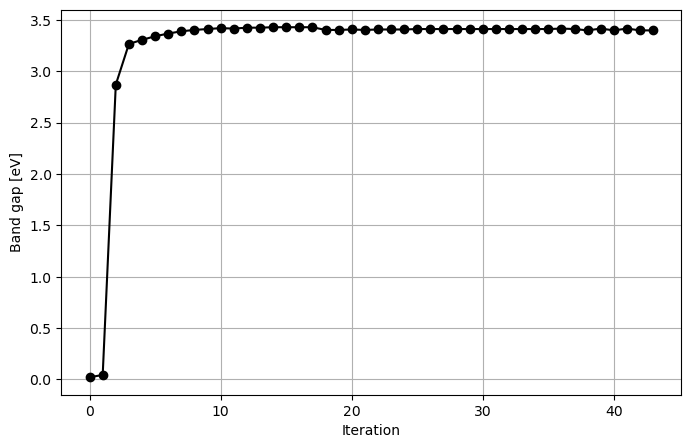

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(band_gaps, "o-", color="k")
ax.set_ylabel("Band gap [eV]")
ax.set_xlabel("Iteration")
ax.grid()

# Spectral plots for all computed quantities

In [13]:
ITERATION = 43  # Choose iteration to plot.

block_sizes = np.load(input_dir / "block_sizes.npy")
num_cells = len(block_sizes)

coulomb_energies = energies - energies[0]
electron_ldos = np.load(output_dir / f"electron_ldos_{ITERATION}.npy")

device_current = np.load(output_dir / f"device_current_{ITERATION}.npy")
meir_wingreen_current = np.load(output_dir / f"meir_wingreen_current_{ITERATION}.npy")

left_fermi_level = config.electron.left_fermi_level
right_fermi_level = config.electron.right_fermi_level

Text(0.5, 0, 'Transport cell Index')

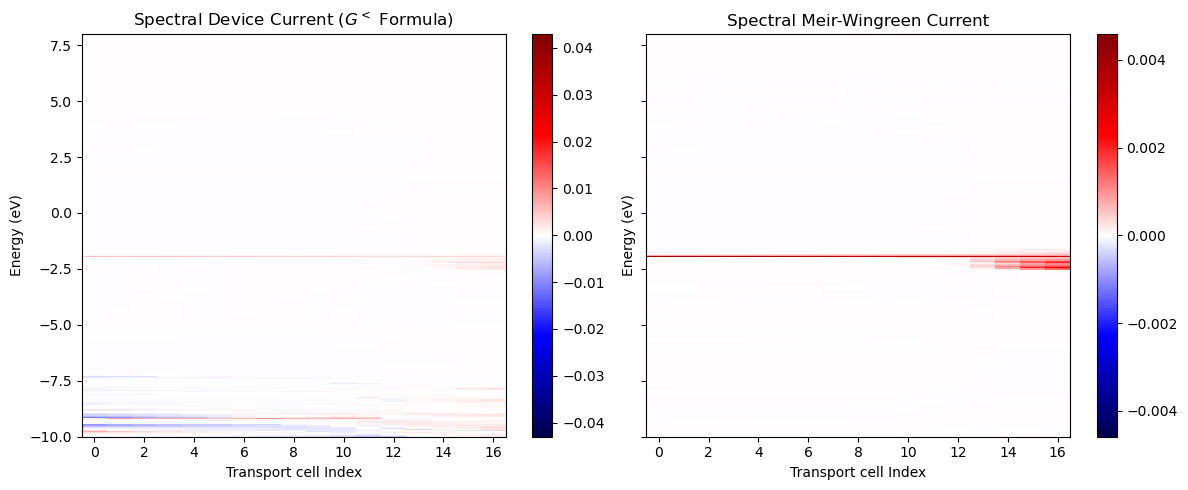

In [14]:
fig, (ax_current, ax_meir_wingreen) = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, layout="tight", sharey=True
)
spectral_plot(
    ax_current,
    device_current.real,
    energies,
    cmap="seismic",
    norm=mpl.colors.CenteredNorm(vcenter=0),
)

# ax_current.set_ylim(-3.5, -1)
ax_current.set_title("Spectral Device Current ($G^{<}$ Formula)")
ax_current.set_xlabel("Transport cell Index")

spectral_plot(
    ax_meir_wingreen,
    -meir_wingreen_current.real,
    energies,
    cmap="seismic",
    norm=mpl.colors.CenteredNorm(vcenter=0),
    # norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-1),
)

ax_meir_wingreen.set_title("Spectral Meir-Wingreen Current")
ax_meir_wingreen.set_xlabel("Transport cell Index")

# ax_meir_wingreen.set_ylim(-3.5, -1)

(-7.0, 0.0)

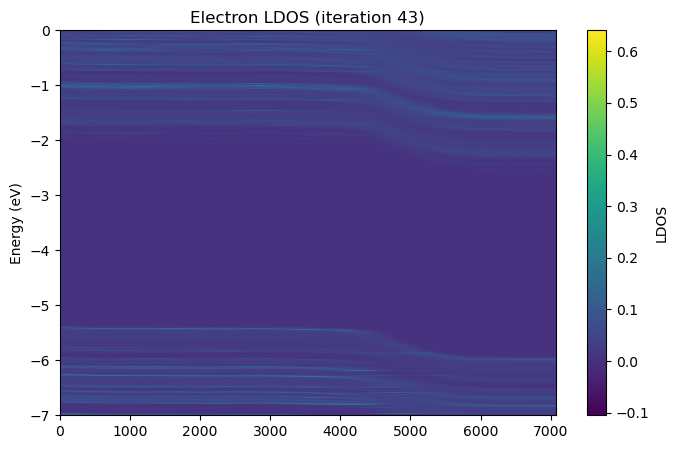

In [15]:
fig, ax_ldos = plt.subplots(figsize=(8, 5))

num_energies = len(energies)
average_ldos = get_averages(
    electron_ldos,
    num_energies,
    num_cells,
    method="rolling",
)

ax_ldos.set_title(f"Electron LDOS (iteration {ITERATION})")
spectral_plot(
    ax_ldos,
    average_ldos,
    energies,
    cmap="viridis",
    colorbar_label="LDOS",
    # norm=mpl.colors.LogNorm(),
)

ax_ldos.set_ylim(-7, 0)